# More Models!

Now let's try to come up with the best model we can for predicting expected goals! In this section, we will try several different models, some feature selection methods and hyperparameter tuning.

## Neural Network

Firstly, we implemented a neural network with the keras library with one hidden layer containing 16 neurons. 

In [1]:
# for model training
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import SGD

# for preprocessing
from sklearn.compose import ColumnTransformer
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from nn_preprocessing import *
from neural_network import *

# for plotting
from utils.plot_utils import *

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Load dataset
df = pd.read_csv('advanced_models_data.csv')

# Preprocess data
X_res_scaled, y_res = preprocess(df)

# Split the data into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res_scaled, y_res, test_size=0.2, shuffle=True)
X_train, y_train = balance_data(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True)  # 0.25 x 0.8 = 0.2

# train model
model, history = train_nn(X_train, y_train, X_val, y_val)

# save model
model.save("models/neural_network_all_ft.keras")

/Users/miloshdevic/opt/miniconda3/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(


Resampled dataset shape Counter({0: 273504, 1: 273504})
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                480       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 497 (1.94 KB)
Trainable params: 497 (1.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
12821/12821 [==============================] - 37s 3ms/step - loss: 0.1026 - accuracy: 0.9761 - val_loss: 0.0578 - val_accuracy: 0.9855
Epoch 2/100
12821/12821 [==============================] - 40s 3ms/step - loss: 0.0522 - accuracy: 0.9854 - val_loss: 0.0565 - val_accuracy: 0.9813
Epoch 3/100
12821/12821 [==============================] - 40s 3ms/ste

In [15]:
# make predictions
predictions = model.predict(X_test)

2355/2355 [==============================] - 4s 2ms/step


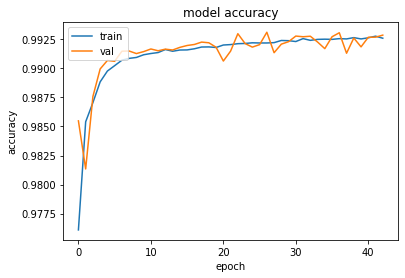

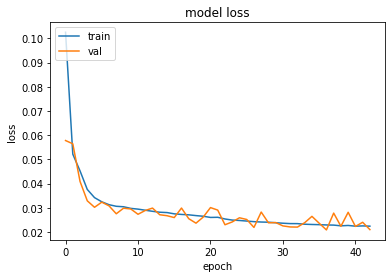

In [4]:
# plot the training accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# plot the training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

2355/2355 [==============================] - 4s 2ms/step - loss: 0.0206 - accuracy: 0.9939
Test accuracy: 99.39%
2355/2355 [==============================] - 3s 1ms/step
0.9819658500663979


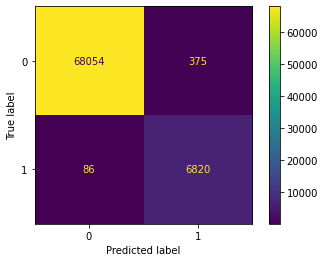

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     68429
           1       0.95      0.99      0.97      6906

    accuracy                           0.99     75335
   macro avg       0.97      0.99      0.98     75335
weighted avg       0.99      0.99      0.99     75335



In [8]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

preds = np.round(model.predict(X_test), 0)

# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

print(f1_score(y_test, preds, average="macro"))
ConfusionMatrixDisplay(confusion_matrix(y_test, preds)).plot()
plt.show()
print(classification_report(y_test, preds))

### Plotting the ROC curve, goal rate vs probability percentile, cumulative proportion of goals vs probability percentile, and the reliability curve

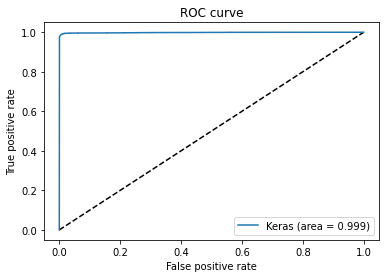

In [9]:
# ROC curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predictions)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [10]:
# make the probability predictions 1D
predictions = predictions.flatten()
predictions

array([1.15451885e-05, 4.39130454e-10, 2.91142642e-04, ...,
       0.00000000e+00, 9.99060690e-01, 5.16390661e-04], dtype=float32)

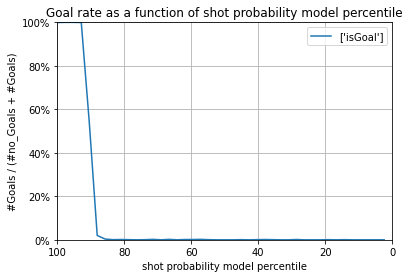

In [12]:
# goal rate vs probability percentile
label = ['isGoal']
percentile = np.arange(0, 102, 2)
pred_percentile = np.percentile(predictions, percentile)
pred_percentile = np.concatenate([[0], pred_percentile])
pred_percentile = np.unique(pred_percentile)
y1_val_df = pd.DataFrame(y_test)
y1_val_df.rename(columns={ y1_val_df.columns[0]: "isGoal" }, inplace = True)
y1_val_df['percentile_bin'] = pd.cut(predictions, pred_percentile, include_lowest=True)
bins = np.linspace(0, 100, len(y1_val_df['percentile_bin'].unique()))[1:]
goal_rate_by_percentile_bin = y1_val_df.groupby(by=['percentile_bin']).apply(lambda f: f['isGoal'].sum()/len(f))
g = sns.lineplot(x=bins, y=goal_rate_by_percentile_bin[1:]*100, label=label)
ax = g.axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.xlabel('shot probability model percentile')
plt.ylabel('#Goals / (#no_Goals + #Goals)')
plt.title('Goal rate as a function of shot probability model percentile')
plt.grid(True)
plt.show()

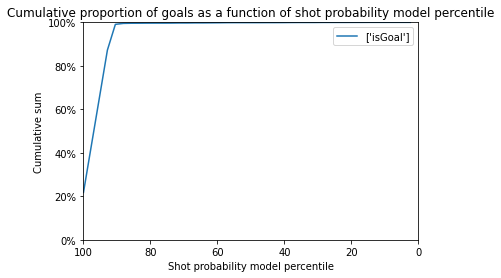

In [13]:
# cumulative proportion of goals vs probability percentile
number_goal_sum = (y_test==1).sum()
sum_goals_by_percentile = y1_val_df.groupby(by='percentile_bin').apply(lambda f: f['isGoal'].sum()/number_goal_sum)
cumu_sum_goals = sum_goals_by_percentile[::-1].cumsum(axis=0)[::-1]
bins = np.linspace(0, 100, len(y1_val_df['percentile_bin'].unique()))[1:]

g = sns.lineplot(x=bins, y=cumu_sum_goals[1:]*100, label=label)
ax = g.axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
        
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.xlabel('Shot probability model percentile')
plt.ylabel('Cumulative sum')
plt.title('Cumulative proportion of goals as a function of shot probability model percentile')
plt.show()

/Users/miloshdevic/opt/miniconda3/lib/python3.9/site-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


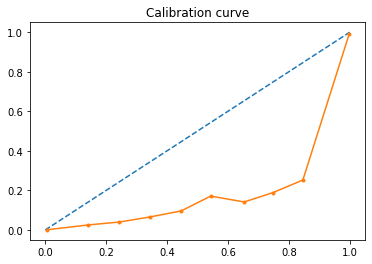

In [16]:
# reliability curve

from sklearn.calibration import calibration_curve

# reliability diagram
fop, mpv = calibration_curve(y_test, predictions, n_bins=10, normalize=True)

# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')

# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.title('Calibration curve')
plt.show()